**1. DESCRIPTION OF THE DATASET** 

Primero quiero poner aquí todas las librerías que vayamos a utilizar:

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


Ahora vendría la parte de importar los datos de excel:

DAVID: Ignora esta celda, no me dejaba importar el dataset

In [2]:
%pip install --upgrade openpyxl

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Load data from Excel (change path to your own)
path = r"C:\Users\david\OneDrive\Escritorio\MSC ENERGY SYSTEMS\MACHINE LEARNING\PROJECT\data\dataset.xlsx"
df = pd.read_excel(path)
print(df.head())

   No  X1 transaction date  X2 house age  \
0   1          2012.916667          32.0   
1   2          2012.916667          19.5   
2   3          2013.583333          13.3   
3   4          2013.500000          13.3   
4   5          2012.833333           5.0   

   X3 distance to the nearest MRT station  X4 number of convenience stores  \
0                                84.87882                               10   
1                               306.59470                                9   
2                               561.98450                                5   
3                               561.98450                                5   
4                               390.56840                                5   

   X5 latitude  X6 longitude  Y house price of unit area  
0     24.98298     121.54024                        37.9  
1     24.98034     121.53951                        42.2  
2     24.98746     121.54391                        47.3  
3     24.98746     121.54391  

Quito la columna No (inutil) y le cambio el nombre a las columnas (más simple y manejable)

In [5]:
# Rename each column
df = df.drop(columns=["No"])
df = df.rename(columns={
    "X1 transaction date": "X1_date",
    "X2 house age": "X2_age",
    "X3 distance to the nearest MRT station": "X3_distMRTT",
    "X4 number of convenience stores": "X4_stores",
    "X5 latitude": "X5_lat",
    "X6 longitude": "X6_lon",
    "Y house price of unit area": "Y1_price"
})
print(df.head())

       X1_date  X2_age  X3_distMRTT  X4_stores    X5_lat     X6_lon  Y1_price
0  2012.916667    32.0     84.87882         10  24.98298  121.54024      37.9
1  2012.916667    19.5    306.59470          9  24.98034  121.53951      42.2
2  2013.583333    13.3    561.98450          5  24.98746  121.54391      47.3
3  2013.500000    13.3    561.98450          5  24.98746  121.54391      54.8
4  2012.833333     5.0    390.56840          5  24.97937  121.54245      43.1


Ya habiendo hecho la descripción del dataset (Task 1 del report), entendemos que hemos de hacer una nueva columna separando el precio de las viviandas en tres tercios por categorías ("low", "medium" y "high").

In [6]:
# Create new column 'Y2 price category' based on quantiles of 'Y house price of unit area'
# Create new column 'Y2 price category' based on quantiles of 'Y house price of unit area'
df['Y2_pcategory'], bins = pd.qcut(
    df['Y1_price'], 
    q=2, 
    labels=['low', 'high'],
    retbins=True
)
print(df.head())


       X1_date  X2_age  X3_distMRTT  X4_stores    X5_lat     X6_lon  Y1_price  \
0  2012.916667    32.0     84.87882         10  24.98298  121.54024      37.9   
1  2012.916667    19.5    306.59470          9  24.98034  121.53951      42.2   
2  2013.583333    13.3    561.98450          5  24.98746  121.54391      47.3   
3  2013.500000    13.3    561.98450          5  24.98746  121.54391      54.8   
4  2012.833333     5.0    390.56840          5  24.97937  121.54245      43.1   

  Y2_pcategory  
0          low  
1         high  
2         high  
3         high  
4         high  


Convertimos las variabes de longitud y latitud a una variable representativa de distancia con respecto al centro de la ciudad

In [7]:
CENTER_LAT, CENTER_LON = 25.0375, 121.5637   # degrees
R = 6371.0  # Earth radius in km

lat1 = np.radians(df["X5_lat"])         # or 'lat' if you renamed
lon1 = np.radians(df["X6_lon"])
lat2 = np.radians(CENTER_LAT)
lon2 = np.radians(CENTER_LON)

dlat = lat2 - lat1
dlon = lon2 - lon1

a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

df["X5_distcenter"] = R * c
df = df.drop(columns=['X5_lat','X6_lon'])


print(df.head().round(2))



   X1_date  X2_age  X3_distMRTT  X4_stores  Y1_price Y2_pcategory  \
0  2012.92    32.0        84.88         10      37.9          low   
1  2012.92    19.5       306.59          9      42.2         high   
2  2013.58    13.3       561.98          5      47.3         high   
3  2013.50    13.3       561.98          5      54.8         high   
4  2012.83     5.0       390.57          5      43.1         high   

   X5_distcenter  
0           6.51  
1           6.81  
2           5.91  
3           5.91  
4           6.81  


In [8]:
df = df[["X1_date", "X2_age", "X3_distMRTT", "X4_stores", "X5_distcenter", "Y1_price", "Y2_pcategory"]]

# Redondear solo las columnas numéricas
df_display = df.head().copy()
numeric_cols = df_display.select_dtypes(include=[np.number]).columns
df_display[numeric_cols] = df_display[numeric_cols].round(2)

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
print(df_display)

   X1_date  X2_age  X3_distMRTT  X4_stores  X5_distcenter  Y1_price Y2_pcategory
0  2012.92    32.0        84.88         10           6.51      37.9          low
1  2012.92    19.5       306.59          9           6.81      42.2         high
2  2013.58    13.3       561.98          5           5.91      47.3         high
3  2013.50    13.3       561.98          5           5.91      54.8         high
4  2012.83     5.0       390.57          5           6.81      43.1         high


**2. DETAILED EXPLANATION OF THE ATTRIBUTES** 

Ahora creo que ya podemos generar una descripción de nuestra base de datos de forma que podamos hacer un resumen con las estadísticas más relevantes de nuestros atributos para incluir en el informe. Por mi parte diría que las estadísticas más relevantes son la media y los rangos de 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores' e 'Y house price of unit area'; el rango de 'X1 transaction date'; los rangos que componen cada una de las categorías de la nueva columna: 'Y2 price category' (describe solo describe columnas numéricas, así que hay que utilizar otros comandos); y, finalmente, conviene comprobar si tenemos algún "missing value".

In [9]:
# General description of dataset.
print("\n Relevant statistics of the dataset")
print(df.describe().round(2))

# Description of dataset categories
price_groups = df.groupby(by=['Y2_pcategory'], observed=False)
print("\n Statistics for each price range")
print(price_groups['Y1_price'].describe().round(2))



 Relevant statistics of the dataset
       X1_date  X2_age  X3_distMRTT  X4_stores  X5_distcenter  Y1_price
count   414.00  414.00       414.00     414.00         414.00    414.00
mean   2013.15   17.71      1083.89       4.09           8.30     37.98
std       0.28   11.39      1262.11       2.95           1.66     13.61
min    2012.67    0.00        23.38       0.00           5.25      7.60
25%    2012.92    9.02       289.32       1.00           7.06     27.70
50%    2013.17   16.10       492.23       4.00           7.87     38.45
75%    2013.42   28.15      1454.28       6.00           9.39     46.60
max    2013.58   43.80      6488.02      10.00          13.48    117.50

 Statistics for each price range
              count   mean   std   min    25%   50%    75%    max
Y2_pcategory                                                     
low           207.0  27.28  7.38   7.6  22.20  27.7  33.50   38.4
high          207.0  48.68  9.30  38.5  42.15  46.6  53.15  117.5


Buscamos missing values

In [10]:
# Missing values
print("\n Missing values per column")
df.isnull().sum()


 Missing values per column


X1_date          0
X2_age           0
X3_distMRTT      0
X4_stores        0
X5_distcenter    0
Y1_price         0
Y2_pcategory     0
dtype: int64

Datos más importantes

In [11]:
# Summary statistics for selected numeric columns
numeric_features = ['X1_date','X2_age', 'X3_distMRTT', 'X4_stores', 'X5_distcenter', 'Y1_price']
print("=== Numeric Attributes Summary ===")
for col in numeric_features:
    print(f"{col}:")
    print(f"  Mean: {df[col].mean():.2f}")
    print(f"  Min: {df[col].min():.2f}")
    print(f"  Max: {df[col].max():.2f}")
    print()

# Ranges for the 'Y2 price category'
print("=== Bin edges for each price category ===")
for i in range(len(bins)-1):
    print(f"{['low','medium','high'][i]}: {bins[i]:.2f} - {bins[i+1]:.2f}")
print()

# Check for missing values
print("=== Missing Values Check ===")
print(df.isnull().sum())

=== Numeric Attributes Summary ===
X1_date:
  Mean: 2013.15
  Min: 2012.67
  Max: 2013.58

X2_age:
  Mean: 17.71
  Min: 0.00
  Max: 43.80

X3_distMRTT:
  Mean: 1083.89
  Min: 23.38
  Max: 6488.02

X4_stores:
  Mean: 4.09
  Min: 0.00
  Max: 10.00

X5_distcenter:
  Mean: 8.30
  Min: 5.25
  Max: 13.48

Y1_price:
  Mean: 37.98
  Min: 7.60
  Max: 117.50

=== Bin edges for each price category ===
low: 7.60 - 38.45
medium: 38.45 - 117.50

=== Missing Values Check ===
X1_date          0
X2_age           0
X3_distMRTT      0
X4_stores        0
X5_distcenter    0
Y1_price         0
Y2_pcategory     0
dtype: int64


Ahora convertimos el dataset en una matriz tal y como hace el profesor en sus ejercicios. Por lo que veo servirá para hacer la estandarización y posteriormente los ejercicios de regresión y clasificación y también para buscar outliers con los plots.

In [12]:
# Features (all columns except the targets)
X = df.drop(columns=['Y1_price', 'Y2_pcategory'])

# Targets (choose one depending on the task: classification or regression)
y_reg   = df['Y1_price']     # for regression
y_class = df['Y2_pcategory']              # for classification

print(df.head())

# Check the shape of the dataset
N, M = X.shape
assert N == 414, "There should be 414 samples in the Real Estate dataset."
assert M == 5,   "There should be 6 features in the Real Estate dataset."
print(f"Dataset contains {N} samples and {M} features.")

       X1_date  X2_age  X3_distMRTT  X4_stores  X5_distcenter  Y1_price Y2_pcategory
0  2012.916667    32.0     84.87882         10       6.506972      37.9          low
1  2012.916667    19.5    306.59470          9       6.807309      42.2         high
2  2013.583333    13.3    561.98450          5       5.910751      47.3         high
3  2013.500000    13.3    561.98450          5       5.910751      54.8         high
4  2012.833333     5.0    390.56840          5       6.809231      43.1         high
Dataset contains 414 samples and 5 features.


Ahora la idea es estandarizar los atributos:

In [13]:
# Standardization of the data matrix X
X_standardized = (X - X.mean(axis=0)) / X.std(axis=0)


Finalmente comenzamos a plottear, de primeras utilizo el estilo que impuso el profe en sus ejercicios:

Ahora vamos con los histogramas (no he añadido el histograma de la categórica porque carece de sentido, al fin y al cabo saldrían tres tercios prácticamente iguales):

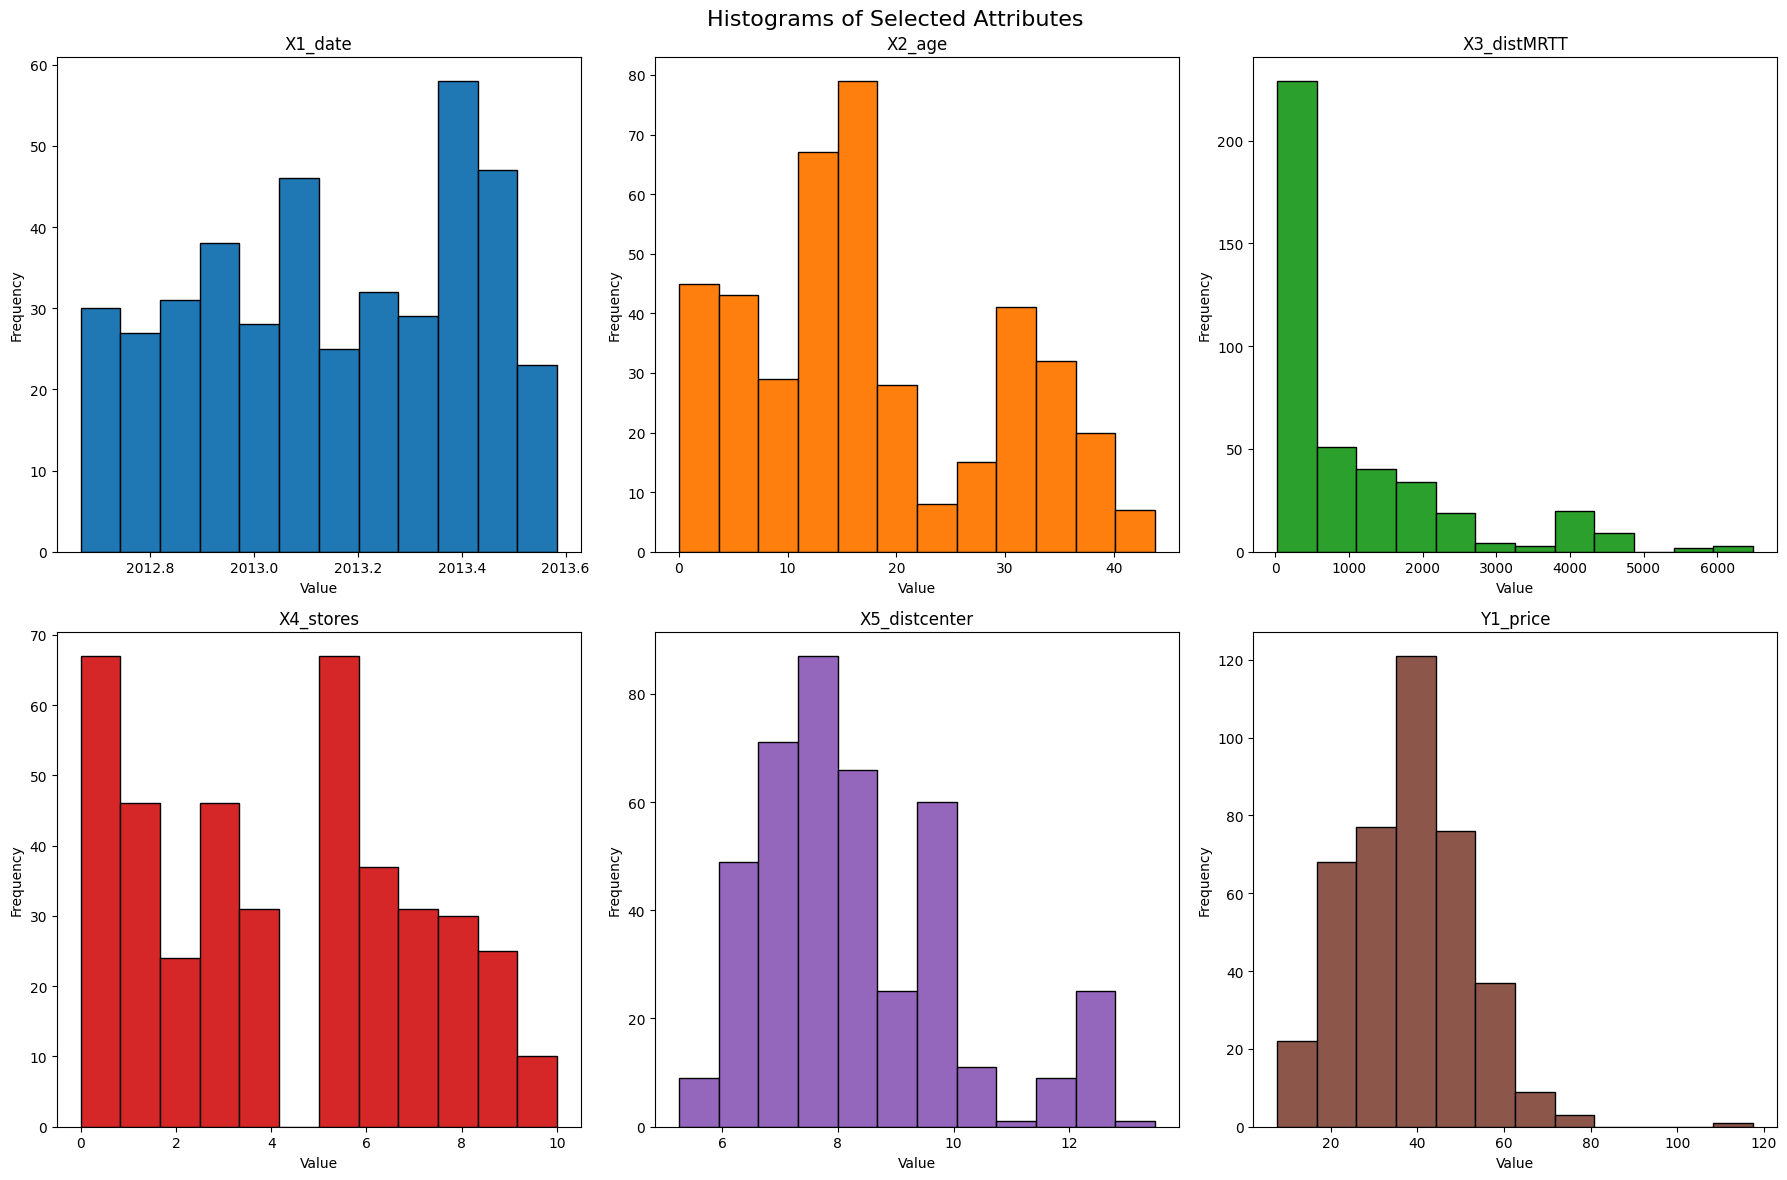

In [14]:
cols = ["X1_date", "X2_age", "X3_distMRTT", "X4_stores", "X5_distcenter", "Y1_price"]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Histograms of Selected Attributes", fontsize=16)
axes = axes.ravel()

for i, col in enumerate(cols):
    axes[i].hist(df[col], bins=12, color=f"C{i}", edgecolor="black")
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Ahora vamos con el boxplot, esta vez con las variables estandarizadas porque sino carece de gracia la gráfica.

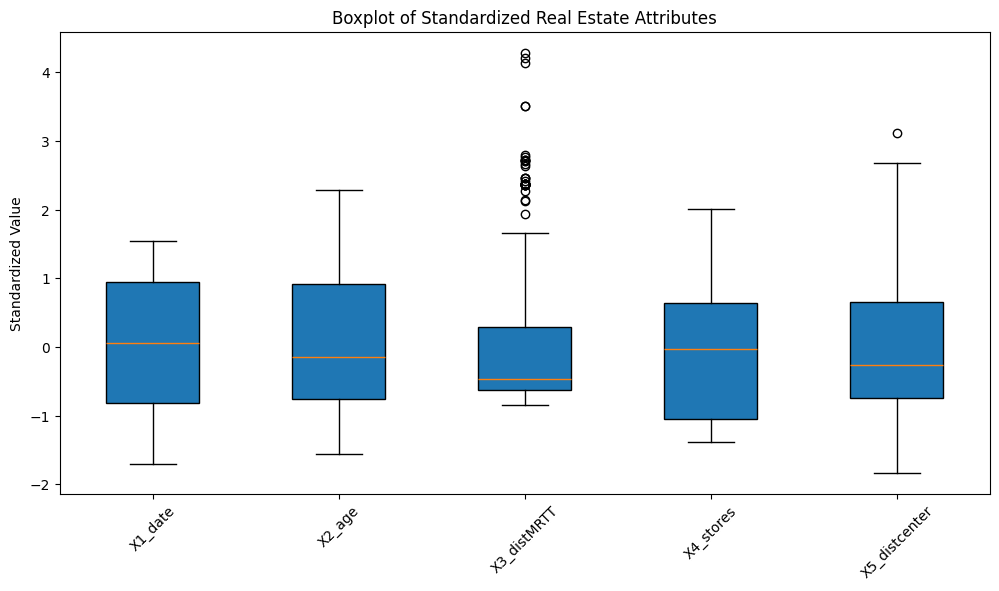

In [15]:
# Boxplot of standardized data (matplotlib)
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot of Standardized Real Estate Attributes")
plt.boxplot(X_standardized.values, vert=True, patch_artist=True, tick_labels=X.columns)
plt.xticks(rotation=45)
plt.ylabel("Standardized Value")
plt.show()

Creo que la transaction date no tiene ninguna utilidad en este plot, y luego la latitud y la longitud, no son outliers los puntos que aparecen fuera de los bigotes. Solo serán sitiós más alejadas de los núcleos dónde más se han vendido casas en ese periodo. No aporta nada. Solo aportaría si supiesemos que esos puntos se correlacionan con que estén mas lejos del centro o con X3 y X4 y serían un outlier si estando super lejos del centro fuese muy caro (por ejemplo). Por ende, no creo que aporten realmente nada la fecha, la longitud y la latitud en esta gráfica.

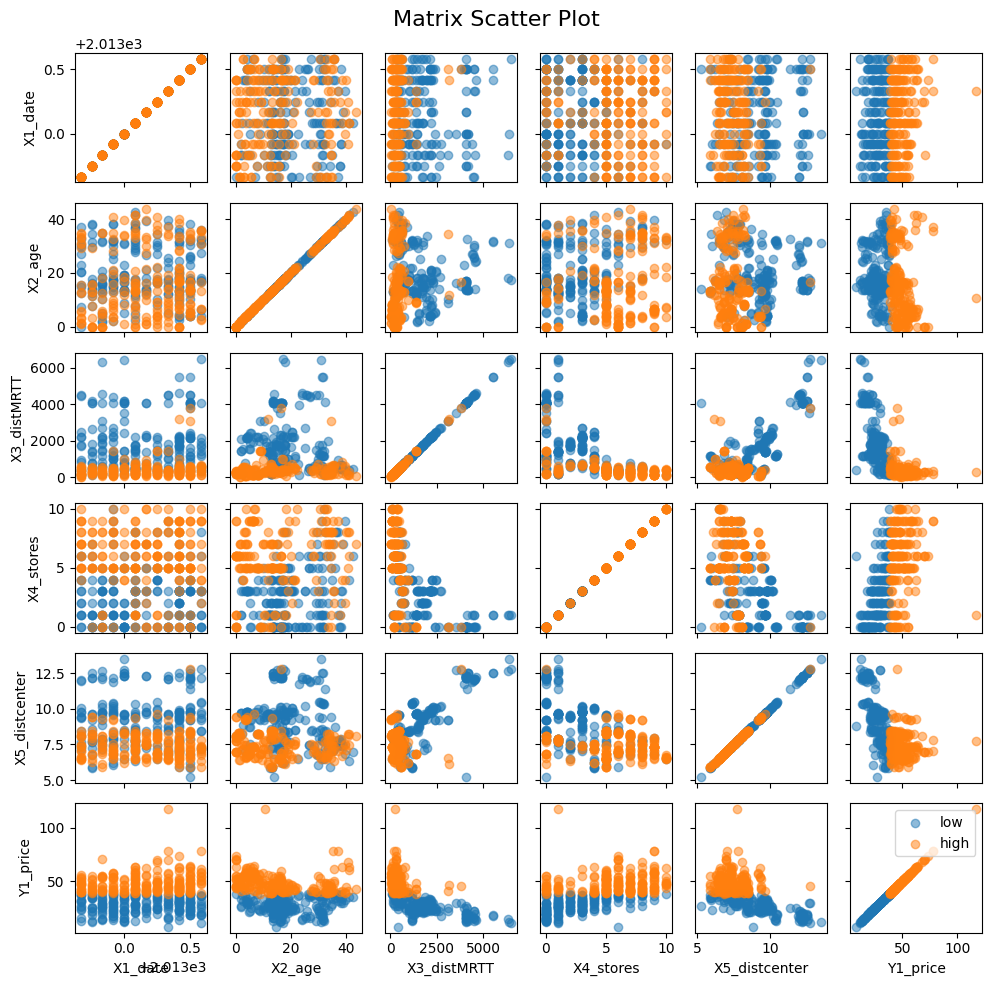

In [16]:
k = len(cols)

fig, axs = plt.subplots(k, k, figsize=(10, 10), sharex='col', sharey='row')
fig.suptitle("Matrix Scatter Plot", fontsize=16)

for i in range(k):
    for j in range(k):
        for category in df["Y2_pcategory"].unique(): # loop through each species
            # Filter the dataframe for the current species
            subset = df.query(f'Y2_pcategory == "{category}"')
            # Plot the scatter plot for attribute pair (if not on the diagonal)
            axs[i, j].scatter(
                x=subset.iloc[:, j],        # x-values for the $j$'th attribute
                y=subset.iloc[:, i],        # y-values for the $i$'th attribute
                label=category, alpha=0.5
            )

        if j == 0: # Set the y-label for the first column
            axs[i, j].set_ylabel(df.columns[i])
        if i == 5: # Set the x-label for the last row
            axs[i, j].set_xlabel(df.columns[j])

# Add the legend to the last subplot only
axs[5,5].legend(loc='upper right')
plt.tight_layout(pad=1.)
plt.show()


Estudiamos la la variable X_trasacyion date para ver que no tiene relevamcia aol estudiarse solo a lo largo de un año y obtenemos los meses para ver si hay relaciones con respecto a la estación del año. Como no es el caso se puede desestimar esta variable

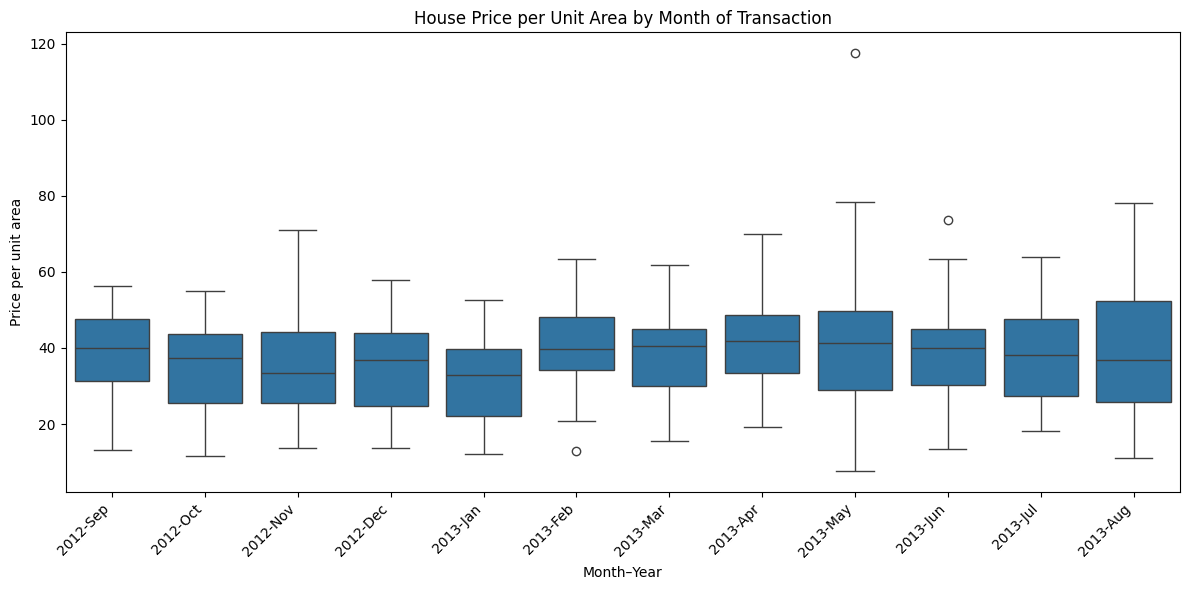

In [17]:
# --- Año y mes desde año fraccional (X1_date) ---
year_int  = np.floor(df["X1_date"]).astype(int)
frac      = df["X1_date"] - year_int

# Redondear al mes correcto (esquema month = round(frac*12) + 1)
month_int = np.rint(frac * 12).astype(int) + 1

df["year"]  = year_int
df["month"] = month_int

# Fecha del primer día del mes (para ordenar y etiquetar)
df["year_month"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))
df["ym_label"]   = df["year_month"].dt.strftime("%Y-%b")

# Orden cronológico usando la fecha real, pero mostramos la etiqueta
order_dt  = np.sort(df["year_month"].unique())
order_lbl = pd.Series(order_dt).dt.strftime("%Y-%b").tolist()

# --- Plot ---
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=df, x="ym_label", y="Y1_price", order=order_lbl)
ax.set_title("House Price per Unit Area by Month of Transaction")
ax.set_xlabel("Month–Year")
ax.set_ylabel("Price per unit area")
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

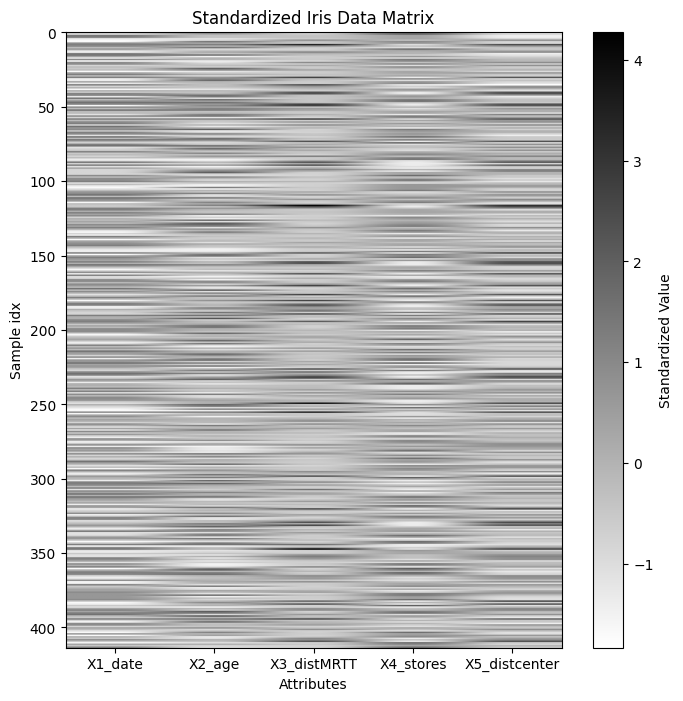

In [18]:
# Plot the standardized data matrix as an image
fig = plt.figure(figsize=(8, 8))
plt.imshow(X_standardized, aspect='auto', cmap='gray_r')
plt.colorbar(label='Standardized Value')
plt.title("Standardized Iris Data Matrix")
plt.xticks(ticks=np.arange(X_standardized.shape[1]), labels=X.columns, rotation=0)
plt.xlabel("Attributes")
plt.ylabel("Sample idx")
plt.grid(False)

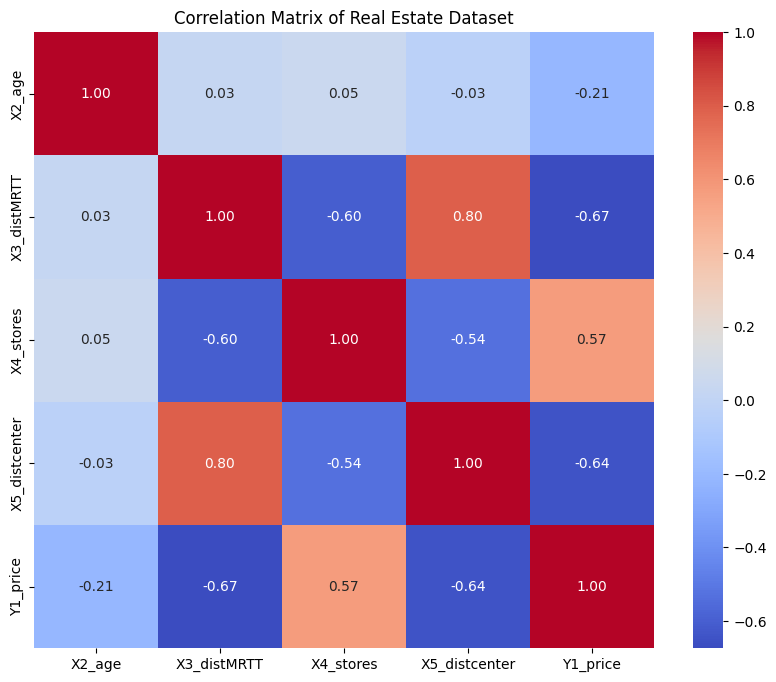

In [19]:
# Compute correlation matrix (numeric columns only, excluding year and month)
df_corr = df.drop(columns=['year', 'month', 'X1_date'])
corr_matrix = df_corr.corr(numeric_only=True)

# Heatmap with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix of Real Estate Dataset")
plt.show()


In [20]:
df_final = df.drop(columns=['year', 'month', 'year_month', 'ym_label'], errors='ignore')
print(df_final.head())

       X1_date  X2_age  X3_distMRTT  X4_stores  X5_distcenter  Y1_price Y2_pcategory
0  2012.916667    32.0     84.87882         10       6.506972      37.9          low
1  2012.916667    19.5    306.59470          9       6.807309      42.2         high
2  2013.583333    13.3    561.98450          5       5.910751      47.3         high
3  2013.500000    13.3    561.98450          5       5.910751      54.8         high
4  2012.833333     5.0    390.56840          5       6.809231      43.1         high
